# Clustering, spatial clustering, and geodemographics

This session covers statistical clustering of spatial observations. Many questions and topics are complex phenomena that involve several dimensions and are hard to summarize into a single variable. In statistical terms, we call this family of problems *multivariate*, as oposed to *univariate* cases where only a single variable is considered in the analysis. Clustering tackles this kind of questions by reducing their dimensionality -the number of relevant variables the analyst needs to look at- and converting it into a more intuitive set of classes that even non-technical audiences can look at and make sense of. For this reason, it is widely use in applied contexts such as policymaking or marketting. In addition, since these methods do not require many preliminar assumptions about the structure of the data, it is a commonly used exploratory tool, as it can quickly give clues about the shape, form and content of a dataset.

The basic idea of statistical clustering is to summarize the information contained in several variables by creating a relatively small number of categories. Each observation in the dataset is then assigned to one, and only one, category depending on its values for the variables originally considered in the classification. If done correctly, the exercise reduces the complexity of a multi-dimensional problem while retaining all the meaningful information contained in the original dataset. This is because, once classified, the analyst only needs to look at in which category every observation falls into, instead of considering the multiple values associated with each of the variables and trying to figure out how to put them together in a coherent sense. When the clustering is performed on observations that represent areas, the technique is often called geodemographic analysis.

Although there exist many techniques to statistically group observations in a dataset, all of them are based on the premise of using a set of attributes to define classes or categories of observations that are similar *within* each of them, but differ *between* groups. How similarity within groups and dissimilarity between them is defined and how the classification algorithm is operationalized is what makes techniques differ and also what makes each of them particularly well suited for specific problems or types of data. As an illustration, we will only dip our toes into one of these methods, K-means, which is probably the most commonly used technique for statistical clustering.

In the case of analysing spatial data, there is a subset of methods that are of particular interest for many common cases in Geographic Data Science. These are the so-called *regionalization* techniques. Regionalization methods can take also many forms and faces but, at their core, they all involve statistical clustering of observations with the additional constraint that observations need to be geographical neighbors to be in the same category. Because of this, rather than category, we will use the term *area* for each observation and *region* for each category, hence regionalization, the construction of regions from smaller areas.

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn import cluster

import numpy as np
np.random.seed(123)

## Data

The dataset we will use in this occasion is an extract from the online website [AirBnb](http://www.airbnb.com). AirBnb is a company that provides a meeting point for people looking for an alternative to a hotel when they visit a city, and locals who want to rent (part of) their house to make some extra money. The website has a continuously updated listing of all the available properties in a given city that customers can check and book through. In addition, the website also provides a feedback mechanism by which both ends, hosts and guests, can rate their experience. Aggregating ratings from guests about the properties where they have stayed, AirBnb provides additional information for every property, such as an overall cleanliness score or an index of how good the host is at communicating with the guests.

The original data are provided at the property level and for the entire London. However, since the total number of properties is very large for the purposes of this notebook, they have been aggregated at the Middle Super Output Area (MSOA), a geographical unit created by the Office of National Statistics. Although the original source contains information for the Greater London, the vast majority of properties are located in Inner London, so the data we will use is restricted to that extent. Even in this case, not every polygon has at least one property. To avoid cases of missing values, the final dataset only contains those MSOAs with at least one property, so there can be average ratings associated with them.

Our goal in this notebook is to create a classification of areas (MSOAs) in Inner London based on the ratings of the AirBnb locations. This will allow us to create a typology for the geography of AirBnb in London and, to the extent the AirBnb locations can say something about the areas where they are located, the classification will help us understand the geography of residential London a bit better. One general caveat about the conclusions we can draw from an analysis like this one that derives from the nature of AirBnb data. On the one hand, this dataset is a good example of the kind of analyses that the data revolution is making possible as, only a few years ago, it would have been very hard to obtain a similarly large survey of properties with ratings like this one. On the other hand, it is important to keep in mind the kinds of biases that these data are subject to and thus the limitations in terms of generalizing findings to the general population. At any rate, this dataset is a great example to learn about statistical clustering of spatial observations, both in a geodemographic as well as in a regionalization.

As usual, before anything, let us set the paths to where we have downloaded the data:

In [2]:
# This will be different on your computer and will depend on where
# you have downloaded the files
path = './'

Note that, in this case, the data are provided as two separate files, so you will have to create a folder (for the example above, named `airbnb`) and place both there.

The main bulk of data is stored in `ilm_abb.geojson` (`ilm` for Inner London MSOAs, `abb` for AirBnb). Let us load it first:

In [65]:
# Read GeoJSON file
abb = gpd.read_file(path+'ilm_abb.geojson')
# Manually set CRS (it might work without depending on 
# machine, but just in case)
abb.crs = {'init': u'epsg:27700'}
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
MSOA_id                        320 non-null object
accommodates                   320 non-null float64
bathrooms                      320 non-null float64
bedrooms                       320 non-null float64
beds                           320 non-null float64
geometry                       320 non-null object
number_of_reviews              320 non-null float64
property_count                 320 non-null int64
review_scores_accuracy         320 non-null float64
review_scores_checkin          320 non-null float64
review_scores_cleanliness      320 non-null float64
review_scores_communication    320 non-null float64
review_scores_location         320 non-null float64
review_scores_rating           320 non-null float64
review_scores_value            320 non-null float64
reviews_per_month              320 non-null float64
dtypes: float64(13), int64(1), object(2)
memory usage: 40.1

Note that, in comparison to previous datasets, this one is provided in a new format, `.geojson`. GeoJSON files are a plain text file (you can open it on any text editor and see its contents) that follows the structure of the JSON format, widely used to exchange information over the web, adapted for geographic data, hence the `geo` at the front. GeoJSON files have gained much popularity with the rise of web mapping and are quickly becoming a de-facto standard for small datasets because they are simple and easy to read in many different platforms. As you can see above, reading them in Python is exactly the same as reading a shapefile, for example.

Before we jump into exploring the data, one additional step that will come in handy down the line. Not every variable in the table is an attribute that we will want for the clustering. In particular, we are interested in review ratings, so we will only consider those. Hence, let us first manually write them so they are easier to subset:

In [66]:
ratings = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
     'review_scores_checkin', 'review_scores_communication', 'review_scores_location', \
     'review_scores_value']

## Getting to know the data

The best way to start exploring the geography of AirBnb ratings is by plotting each of them into a different map. This will give us a univariate perspective on each of the variables we are interested in.

Since we have many columns to plot, we will create a loop that generates each map for us and places it on a "subplot" of the main figure:

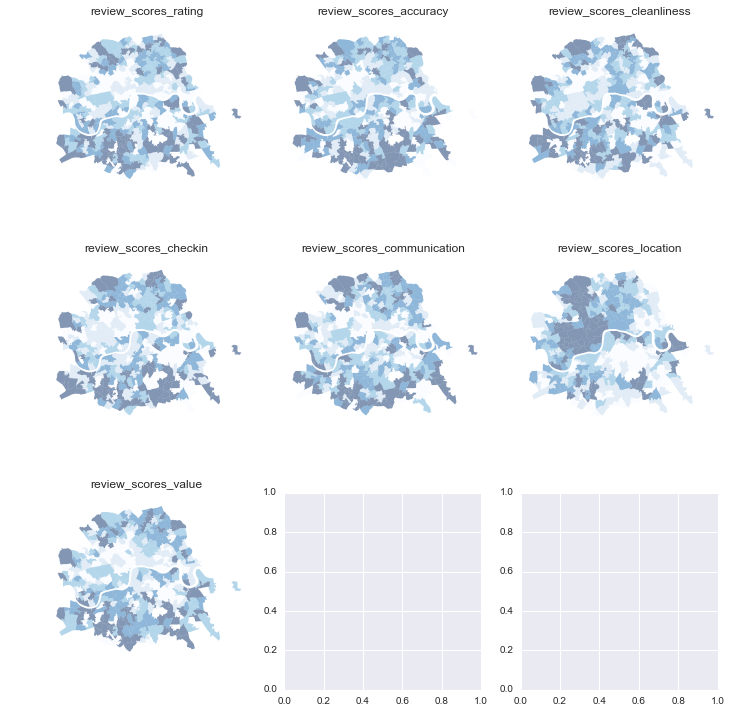

In [5]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(ratings):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    abb.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='Blues')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

As we can see, there is substantial variation in how the ratings for different aspects are distributed over space. While variables like the overall value (`review_scores_value`) or the communication (`review_scores_communication`) tend to higher in peripheral areas, others like the location score (`review_scores_location`) are heavily concentrated in the city centre.

Even though we only have seven variables, it is very hard to "mentally overlay" all of them to come up with an overall assessment of the nature of each part of London. For bivariate correlations, a useful tool is the correlation matrix plot, available in `seaborn`:

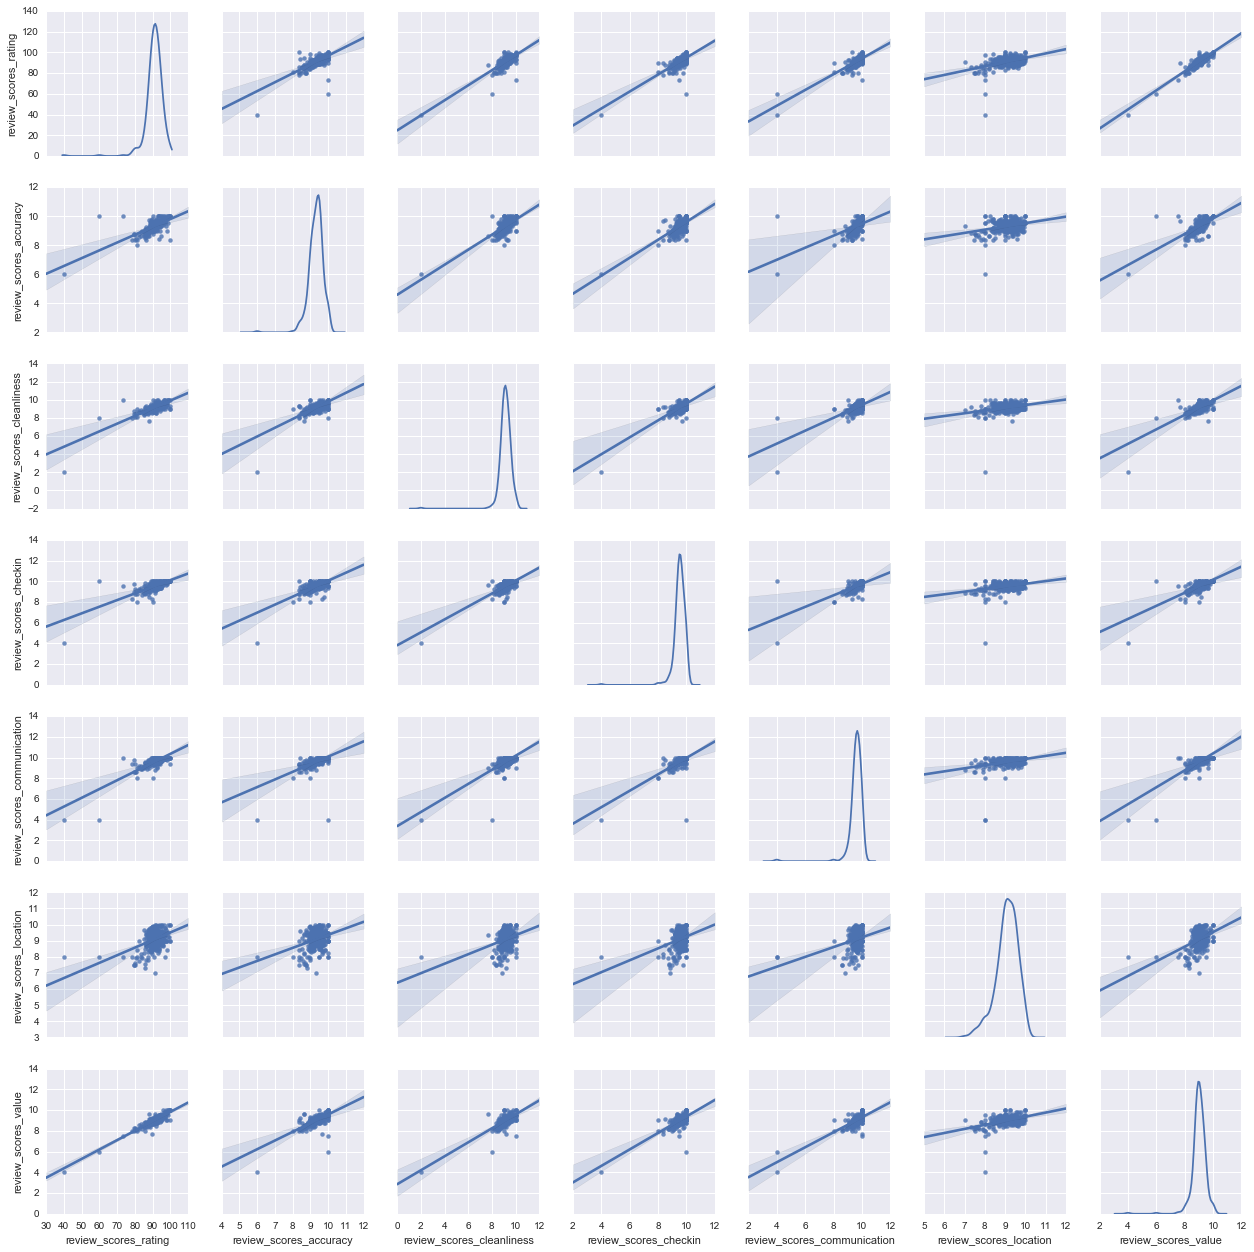

In [48]:
_ = sns.pairplot(abb[ratings], kind='reg', diag_kind='kde')

---

**[Optional exercise]**

Explore the help and the `seaborn` tutorial (find it on Google) for the function `pairplot` and experiment with some of the parameters. For example, recreate the figure above replacing the KDE plots with histograms.

---

This is helpful to consider uni and bivariate questions such as: *what is the relationship between the overall (`rating`) and location scores?* (Positive) *Are the overall ratings more correlated with location or with cleanliness?* (Cleanliness) However, sometimes, this is not enough and we are interested in more sophisticated questions that are truly multivariate and, in these cases, the figure above cannot help us. For example, it is not straightforward to answer questions like: *what are the main characteristics of the South of London?* *What areas are similar to the core of the city?* *Are the East and West of London similar in terms of the kind of AirBnb properties you can find in them?* For these kinds of multi-dimensional questions -involving multiple variables at the same time- we require a truly multidimensional method like statistical clustering.

## An AirBnb geodemographic classification of Inner London using K-means

A geodemographic analysis involves the classification of the areas that make up a greographical map into groups or categories of observations that are similar within each other but different between them. The classification is carried out using a statistical clustering algorithm that takes as input a set of attributes and returns the group ("labels" in the terminology) each observation belongs to. Depending on the particular algorithm employed, additional parameters, such as the desired number of clusters employed or more advanced tuning parameters (e.g. bandwith, radius, etc.), also need to be entered as inputs. For our geodemographic classification of AirBnb ratings in Inner London, we will use one of the most popular clustering algorithms: K-means. This technique only requires as input the observation attributes and the final number of groups that we want it to cluster the observations into. In our case, we will use five to begin with as this will allow us to have a closer look into each of them.

Although the underlying algorithm is not trivial, running K-means in Python is fairly straightforward thanks to `scikit-learn`. Similar to the extensive set of available algorithms in the library, its computation is a matter of two lines of code. First, we need to specify the parameters in the `KMeans` method (which is part of `scikit-learn`'s `cluster` submodule). Note that, at this point, we do not even need to pass the data:

In [67]:
kmeans5 = cluster.KMeans(n_clusters=5, random_state=500)

This sets up an object that holds all the parameters required to run the algorithm. In our case, we only passed the number of clusters, but there are several other ones set by default:

In [68]:
kmeans5

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=500, tol=0.0001,
    verbose=0)

To actually run the algorithm on the attributes, we need to call the `fit` method in `kmeans13`:

In [69]:
k5cls = kmeans5.fit(abb[ratings])

The `k5cls` object we have just created contains several components that can be useful for an analysis. For now, we will use the labels, which represent the different categories in which we have grouped the data. Remember, in Python, life starts at zero, so the group labels go from zero to four. Labels can be  extracted as follows:

In [70]:
k5cls.labels_

array([1, 3, 0, 3, 1, 3, 0, 0, 3, 3, 1, 3, 0, 1, 3, 3, 0, 0, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 3, 0, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 1, 0, 3, 3, 3, 0, 3, 3, 3, 0, 4, 4, 1, 1, 1, 1, 0, 1, 0, 3, 3,
       3, 3, 3, 1, 1, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3,
       3, 0, 3, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 1, 3, 3, 3, 3, 3, 0, 1, 0, 4, 3, 2, 3,
       1, 4, 4, 4, 0, 1, 3, 3, 1, 3, 0, 0, 1, 3, 0, 4, 0, 3, 3, 3, 1, 0, 0,
       1, 3, 2, 0, 3, 3, 3, 3, 3, 0, 0, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1,
       3, 4, 1, 0, 3, 0, 1, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 1, 3, 1, 1, 1, 0,
       1, 1, 1, 1, 4, 3, 3, 3, 1, 4, 1, 1, 1, 1, 1, 1, 3, 0, 3, 3, 1, 3, 0,
       3, 1, 0, 3, 0, 3, 3, 0, 0, 0, 3, 0, 0, 3, 3, 4, 3, 0, 0, 3, 0, 0, 0,
       0, 3, 0, 1, 0, 4, 3, 1, 0, 3, 1, 1, 4, 1, 3, 3, 1, 4, 1, 1, 1, 3, 1,
       1, 1,

Each number represents a different category, so two observations with the same number belong to same group. The labels are returned in the same order as the input attributes were passed in, which means we can append them to the original table of data as an additional column:

In [71]:
abb['k5cls'] = k5cls.labels_

### Mapping the categories

To get a better understanding of the classification we have just performed, it is useful to display the categories created on a map. For this, we will use a unique values choropleth, which will automatically assign a different color to each category:

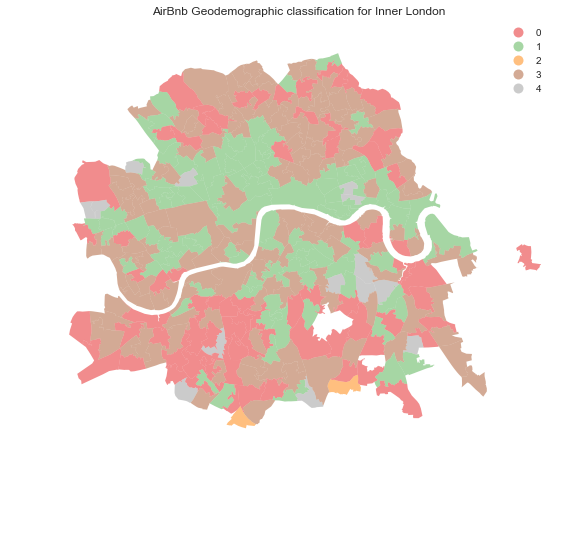

In [72]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic classification for Inner London')
# Display the map
plt.show()

The map above represents the geographical distribution of the five categories created by the K-means algorithm. A
quick glance a strong spatial structure in the distribution of the colors: group four (grey) is mostly found in the city centre and barely in the periphery, while group two (orange) is the opposite. Group zero (red) is an intermediate one, while group three (brown) and one (green) are much smaller, containing only a small number of observations.

### Exploring the nature of the categories

Once we have a sense of where and how the categories are distributed over space, it is also useful to explore them statistically. This will allow us to characterize them, giving us an idea of the kind of observations subsumed into each of them. As a first step, let us find how many observations are in each category. To do that, we will make use of the `groupby` operator introduced before, combined with the function `size`, which returns the number of elements in a subgroup:

In [73]:
k5sizes = abb.groupby('k5cls').size()
k5sizes

k5cls
0     74
1     98
2      2
3    132
4     14
dtype: int64

The `groupby` operator groups a table (`DataFrame`) using the values in the column provided (`k5cls`) and passes them onto the function provided aftwerards, which in this case is `size`. Effectively, what this does is to groupby the observations by the categories created and count how many of them each contains. For a more visual representation of the output, a bar plot is a good alternative:

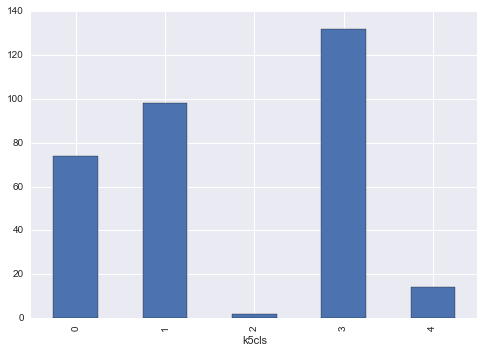

In [74]:
_ = k5sizes.plot(kind='bar')

As we suspected from the map, groups varying sizes.

In order to describe the nature of each category, we can look at the values of each of the attributes we have used to create them in the first place. Remember we used the average ratings on many aspects (cleanliness, communication of the host, etc.) to create the classification, so we can begin by checking the average value of each. To do that in Python, we will rely again on the `groupby` operator but, in this case, we will combine it with the function `mean`:

In [15]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[ratings].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
review_scores_rating,92.090661,50.0,80.693227,96.043939,88.433987
review_scores_accuracy,9.397480,8.0,8.688363,9.629525,9.111175
review_scores_cleanliness,9.229651,5.0,8.634376,9.496462,8.941158
review_scores_checkin,9.577390,7.0,8.997941,9.827215,9.373762
review_scores_communication,9.666776,4.0,9.034868,9.867667,9.473940
review_scores_location,9.180957,8.0,7.944803,9.299225,9.002010
review_scores_value,9.092066,5.0,8.178255,9.452157,8.788526


Or we can try to get a more comprehensive description and include also the quartiles and the standard deviation by calling the function `describe` instead of simply `mean`:

In [16]:
# Calculate the summary by group
k5desc = abb.groupby('k5cls')[ratings].describe()
# Show the table
k5desc

review_scores_rating  review_scores_accuracy  \
k5cls                                                       
0     count            135.000000              135.000000   
      mean              92.090661                9.397480   
      std                1.049664                0.222214   
      min               90.357143                8.400000   
      25%               91.213637                9.276363   
      50%               92.000000                9.400000   
      75%               92.877145                9.500000   
      max               94.066667               10.000000   
1     count              2.000000                2.000000   
      mean              50.000000                8.000000   
      std               14.142136                2.828427   
      min               40.000000                6.000000   
      25%               45.000000                7.000000   
      50%               50.000000                8.000000   
      75%               55.000000                9.000000   
      max               60.000000               10.000000   
2     count             14.000000               14.000000   
      mean              80.693227                8.688363   
      std                2.670005                0.461738   
      min               73.500000                8.000000   
      25%               79.796875                8.394886   
      50%               80.760823                8.669643   
      75%               82.459524                8.770834   
      max               83.900000               10.000000   
3     count             68.000000               68.000000   
      mean              96.043939                9.629525   
      std                1.696025                0.299746   
      min               94.120690                8.333333   
      25%               94.568572                9.500000   
      50%               95.596491                9.640625   
      75%               97.000000                9.804545   
      max              100.000000               10.000000   
4     count            101.000000              101.000000   
      mean              88.433987                9.111175   
      std                1.380477                0.274602   
      min               84.967742                8.363636   
      25%               87.700000                8.975000   
      50%               88.666667                9.086957   
      75%               89.538462                9.233333   
      max               90.272727               10.000000   

             review_scores_cleanliness  review_scores_checkin  \
k5cls                                                           
0     count                 135.000000             135.000000   
      mean                    9.229651               9.577390   
      std                     0.274769               0.207802   
      min                     8.500000               8.833333   
      25%                     9.055303               9.458059   
      50%                     9.227273               9.571429   
      75%                     9.436508               9.700000   
      max                    10.000000              10.000000   
1     count                   2.000000               2.000000   
      mean                    5.000000               7.000000   
      std                     4.242641               4.242641   
      min                     2.000000               4.000000   
      25%                     3.500000               5.500000   
      50%                     5.000000               7.000000   
      75%                     6.500000               8.500000   
      max                     8.000000              10.000000   
2     count                  14.000000              14.000000   
      mean                    8.634376               8.997941   
      std                     0.491434               0.454560   
      min                     8.000000               8.000000   
      25%           

However this approach quickly grows out of hand and the tables become very large to easily communicate any pattern. A good alternative is to visualize the distribution of values by category. The following optional extension shows how to transform the data so it is easy to create a fairly sophisticated plot that summarizes the table above.

---

**[Optional extension]**

To do this conveniently, we need to "tidy up" the table of values. Recall the meaning of *tidy* in the context of data: a dataset is tidy if every row represents an individual observation and every column a single variable. The table we want to plot to replace the summary above contains the following data:

In [17]:
# Name (index) the rows after the category they belong
to_plot = abb.set_index('k5cls')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[ratings]
# Display top of the table
to_plot.head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
k5cls,,,,,,,
4,90.000000,9.244681,9.265957,9.531915,9.542553,9.521277,8.914894
0,92.000000,9.500000,9.500000,10.000000,10.000000,10.000000,9.000000
3,95.526316,9.684211,9.526316,9.894737,10.000000,9.947368,9.421053
0,92.000000,9.400000,9.000000,9.800000,9.600000,9.000000,9.200000
4,88.857143,9.000000,9.071429,9.571429,9.428571,9.500000,8.714286


Following the definition of "tidy data", the table above does not quality as tidy: the names of the columns are a variable in itself, the type of rating that the value represents. If we want to tidy up the table, the column names need to be squeezed into a single column -type of rating. This operation, in `pandas` is called to "stack" a table, and can easily be accomplished as follows:

In [18]:
to_plot = to_plot.stack()
to_plot.head()

k5cls                             
4      review_scores_rating           90.000000
       review_scores_accuracy          9.244681
       review_scores_cleanliness       9.265957
       review_scores_checkin           9.531915
       review_scores_communication     9.542553
dtype: float64

This returns a multi-indexed object. To keep things simple, we can convert it into a `DataFrame` by treating the index as additional columns:

In [19]:
to_plot = to_plot.reset_index()
to_plot.head()

,k5cls,level_1,0
0,4,review_scores_rating,90.000000
1,4,review_scores_accuracy,9.244681
2,4,review_scores_cleanliness,9.265957
3,4,review_scores_checkin,9.531915
4,4,review_scores_communication,9.542553


Finally, we can rename the columns to give them more meaningful names:

In [21]:
to_plot = to_plot.rename(columns={'level_1': 'Rating', 0: 'Values'})
to_plot.head()

,k5cls,Rating,Values
0,4,review_scores_rating,90.000000
1,4,review_scores_accuracy,9.244681
2,4,review_scores_cleanliness,9.265957
3,4,review_scores_checkin,9.531915
4,4,review_scores_communication,9.542553


At this point, we are ready to visualize the distribution of values by type of rating by category. This is done in two steps:

1. Set up of the axis ("facet") to plot by variable.
1. Building of the plot

Let us show the code first and we will explain it afterwards:

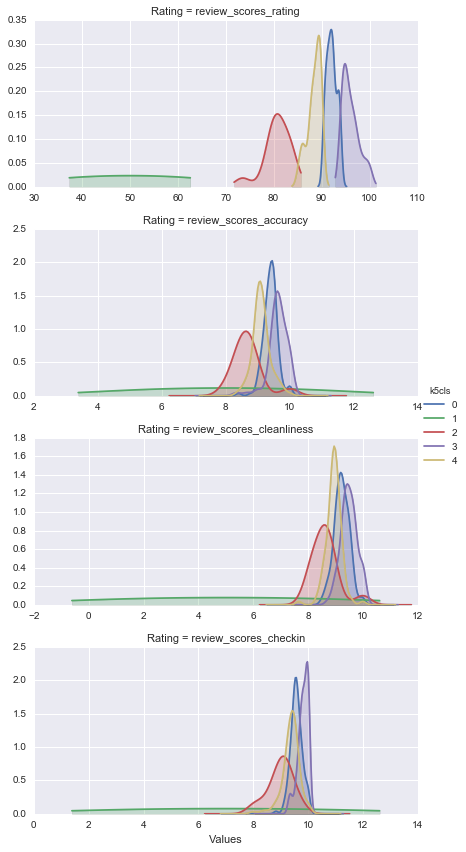

In [22]:
# Setup the facets
ratings_to_plot = to_plot[to_plot['Rating'].isin(['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin'])]
facets = sns.FacetGrid(data=ratings_to_plot, row='Rating', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2)
# Build the plot as a `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

Let us work through the logic of the lines of code above. First, the setup of facets (lines 2-3):

* What we are doing here is creating the "frames" onto which we will later plot. This part is crucial because here is where we specify the variables that we want to split the dataset into.
* We first pass the tidy dataset (`tidy`) to the argument `data`.
* Then we specify the argument `row` which controls how we will split the table `tidy` into plots that will take a different row each. In this case, we use the `Rating` column because we want a single plot for each type of rating (one for the overall rating, one for cleanliness, etc.).
* The next argument is `hue` which is another one to split the data into but, instead of defining differnt plots (as was the case for `row`), `hue` will split the data to create different elements in the same plot. In our case, this means that the split we specify here, by category (`k5cls`), will create different kernel densities within the same plot.
* The arguments `sharex` and `sharey`, which are set to `False`, imply that the scale of the horizontal and vertical axes respectively is not shared across plots. This makes different plots not directly comparable with each other, but generates graphs that make the best use of the available space, resulting in clearer visualizations.
* Finally, `aspect` controls the ratio of height and width of each plot. By setting it to 2, we create plots double long than high.

Once the "shell" of the figure is set up, the second part (line 5) provides the visual characteristics of each of the plots to be created. This is done by calling the function `map` on the `facets` object and specifying the following arguments:

* The first one is the function that we will use to plot the data. Because we want to visualize the distribution of values for each subgroup, we will use `sns.kdeplot`, which creates a kernel density estimation.
* The second one represents, on the data table specified before (`tidy` in our case), which values we want to plot. We pass the variable `Values`.
* Then is additional style arguments for `sns.kdeplot`. To color the area under the line, we set `shade` to `True`.
* Finally, we add an additional call, outside the `map` function to include a global legend with `add_legend`.

In substantive terms, the visualization shows the differences in each of the ratings by clustering group. Although in some cases, as in the checkin, these are not very large, others are more useful in stablishing differences across categories. For example, singles out group two (purple in the plots) as notably worse than the rest which, if we refer to the map we created above, corresponds with areas in orange. Both the overall rating and the rating in terms of value (`review_scores_value`) establishes a hierarchy of categories by which the best is group three (brown areas in the map), then goes group zero (red in the map), followed by group four (grey areas in the map), and then group two (orange in the map). The visualization also makes clear that group one (yellow lines in the plots, green in the map) contains too little observations and too much noise to provide any meaningful information.

---

This concludes the section on geodemographics. As we have seen, the essence of this approach is to group areas based on a purely statistical basis: *where* each area is located is irrelevant for the label it receives from the clustering algorithm. In many contexts, this is not only permissible but even desirable, as the interest is to see if particular combinations of values are distributed over space in any discernible way. However, in other context, we may be interested in created groups of observations that follow certain spatial constraints. For that, we now turn into regionalization techniques.

---

**[Exercise]**

Create a new classification with 10 groups. Compare the output maps between the two solutions.

---

**PCA for clustering**

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(abb[ratings])

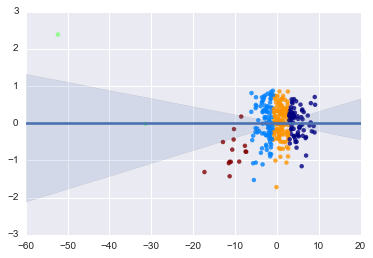

In [98]:
sns.regplot(pca_result[:,0],pca_result[:,1], scatter_kws={'c':abb['k5cls'], 'cmap':'jet'})

** Excersise**
Explore other graphs

** Combining Google Places Data **

In [ ]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

df = pd.read_csv('londonPlaces.csv')

geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = df.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)

In [ ]:
from geopandas.tools import sjoin
geo_df = geo_df.to_crs(abb.crs)
sj = sjoin(abb, geo_df, how='left')

In [52]:
venue_types = list(sj['type'].unique())

In [ ]:
groups = sj.groupby(['type', 'MSOA_id']).groups

In [53]:
for venue_type in venue_types:
    abb[venue_type] = abb['MSOA_id'].apply(lambda msoa: len(groups.get((venue_type, msoa), [])))

** Excersise**
Make a clustering based on the google places data

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'15 - Lab 8</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.